In [1]:
!python -m pip install --upgrade TensorFlow

In [27]:
#Import needed libraries
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import sys
import tensorflow as tf
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
#Import the data from Amazon, IMDB, and Yelp
amazon = pd.read_csv(r'C:\Users\Saemi\OneDrive\Education\WGU\D213 Advanced Data Analytics\PA\PA2 Sentiment Analysis Using Neural Networks\sentiment labelled sentences\amazon_cells_labelled.txt', delimiter='\t', header=None, names=['Reviews', 'Sentiment'])
amazon['Source'] = 'Amazon'
imdb = pd.read_csv(r'C:\Users\Saemi\OneDrive\Education\WGU\D213 Advanced Data Analytics\PA\PA2 Sentiment Analysis Using Neural Networks\sentiment labelled sentences\imdb_labelled.txt', delimiter='\t', header=None, names=['Reviews', 'Sentiment'])
imdb['Source'] = 'IMDB'
yelp = pd.read_csv(r'C:\Users\Saemi\OneDrive\Education\WGU\D213 Advanced Data Analytics\PA\PA2 Sentiment Analysis Using Neural Networks\sentiment labelled sentences\yelp_labelled.txt', delimiter='\t', header=None, names=['Reviews', 'Sentiment'])
yelp['Source'] = 'Yelp'
df = pd.concat([amazon, imdb, yelp], ignore_index=True)
df.columns = ['Reviews', 'Sentiment', 'Source']
df.Sentiment = df.Sentiment.astype(int)

df.shape

(2748, 3)

In [5]:
df.head()

,Reviews,Sentiment,Source
0,So there is no way for me to plug it in here i...,0,Amazon
1,"Good case, Excellent value.",1,Amazon
2,Great for the jawbone.,1,Amazon
3,Tied to charger for conversations lasting more...,0,Amazon
4,The mic is great.,1,Amazon


<Axes: xlabel='Sentiment', ylabel='count'>

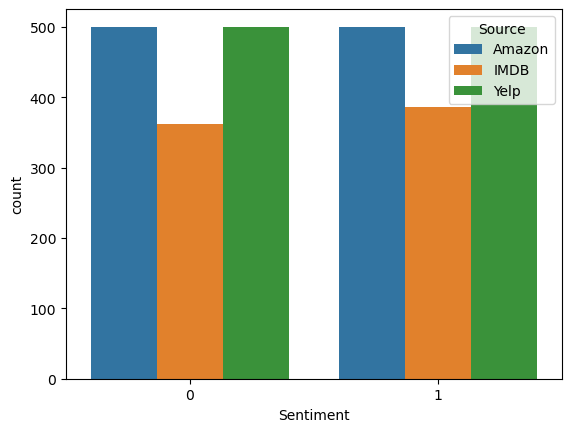

In [28]:
sns.countplot(df, x='Sentiment', hue='Source') #seaborn.countplot

In [7]:
#Download packages for stopwords, punkt, and wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

tokenized_list=[]
cleaned_list=[]
frequent_list=[]
stop_words = stopwords.words('english')

for description in df['Reviews']:
    #Remove special characters from string using regex
    description = re.sub('[^a-zA-Z0-9]', ' ', description)
    #Convert to lower case
    description_lower = description.lower()
    #Perform tokenization
    description_tokenized = nltk.word_tokenize(description_lower)
    #Perform lemmatization
    lemma = nltk.WordNetLemmatizer()
    description_lemma = [lemma.lemmatize(word) for word in description_tokenized]
    tokenized_list.append(description_lemma)
    #Removing stopwords
    description_no_stopwords = [word for word in description_lemma if not word in stop_words]
    description_no_stopwords = " ".join(description_no_stopwords)
    description_tokenized2 = nltk.word_tokenize(description_no_stopwords)
    cleaned_list.append(description_tokenized2)
    #Removing infrequent words
    description_freq = [word for word in description_tokenized2 if len(word)>3]
    description_tokenized3 = " ".join(description_freq)
    frequent_list.append(description_tokenized3)
    
#Add the tokenized_list and cleaned_list to the dataframe
df['Tokenized'] = pd.DataFrame(zip(tokenized_list))
df['No_Stopwords'] = pd.DataFrame(zip(cleaned_list))
df['Frequent'] = pd.DataFrame(frequent_list)
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saemi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saemi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Saemi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Reviews,Sentiment,Source,Tokenized,No_Stopwords,Frequent
0,So there is no way for me to plug it in here i...,0,Amazon,"[so, there, is, no, way, for, me, to, plug, it...","[way, plug, u, unless, go, converter]",plug unless converter
1,"Good case, Excellent value.",1,Amazon,"[good, case, excellent, value]","[good, case, excellent, value]",good case excellent value
2,Great for the jawbone.,1,Amazon,"[great, for, the, jawbone]","[great, jawbone]",great jawbone
3,Tied to charger for conversations lasting more...,0,Amazon,"[tied, to, charger, for, conversation, lasting...","[tied, charger, conversation, lasting, 45, min...",tied charger conversation lasting minute major...
4,The mic is great.,1,Amazon,"[the, mic, is, great]","[mic, great]",great
5,I have to jiggle the plug to get it to line up...,0,Amazon,"[i, have, to, jiggle, the, plug, to, get, it, ...","[jiggle, plug, get, line, right, get, decent, ...",jiggle plug line right decent volume
6,If you have several dozen or several hundred c...,0,Amazon,"[if, you, have, several, dozen, or, several, h...","[several, dozen, several, hundred, contact, im...",several dozen several hundred contact imagine ...
7,If you are Razr owner...you must have this!,1,Amazon,"[if, you, are, razr, owner, you, must, have, t...","[razr, owner, must]",razr owner must
8,"Needless to say, I wasted my money.",0,Amazon,"[needle, to, say, i, wasted, my, money]","[needle, say, wasted, money]",needle wasted money
9,What a waste of money and time!.,0,Amazon,"[what, a, waste, of, money, and, time]","[waste, money, time]",waste money time


In [8]:
df.to_csv('cleaned_data.csv')

In [9]:
#Identify vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(frequent_list)
vocab_size = len(tokenizer.word_index)+1
print("vocabulary size: ", vocab_size)

vocabulary size:  4284


In [10]:
#Identify the embedding size
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Max sequence embedding: ', max_sequence_embedding)

Max sequence embedding:  8


In [13]:
#Make long string out of entire Frequent column
def entire_string (df, column):
    entire = (' '.join(word for word in df[column]))
    entire_tokenized = nltk.word_tokenize(entire)
    return entire_tokenized

In [14]:
#Determine min, med, and max legnths of reviews
review_length = []
for index, row in df.iterrows():
    review_length.append(len(entire_string(row, 'Frequent')))

review_max = int(np.max(review_length))
review_min = int(np.min(review_length))
review_median = int(np.median(review_length))
print('Max length of the sequence is: ', review_max)
print('Min length of the sequence is: ', review_min)
print('Median length of the sequence is: ', review_median)

Max length of the sequence is:  3971
Min length of the sequence is:  0
Median length of the sequence is:  27


In [15]:
#Split the data to train and test sets
split = round(len(df)*0.8)

X_train = df['Frequent'][:split]
X_test = df['Frequent'][split:]
y_train = df['Sentiment'][:split]
y_test = df['Sentiment'][split:]

In [16]:
paddnig='post'
truncating='post'

#Apply padding to training data
review_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(review_train, maxlen=review_median, padding=paddnig, truncating=truncating)

#Apply padding to test data
review_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(review_test, maxlen=review_median, padding=paddnig, truncating=truncating)

#Display added sequences
np.set_printoptions(threshold=sys.maxsize)
padded_train[1]

array([  1,  46,  27, 267,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])

In [17]:
#Convert padded data to numpy array to be used in the model
training_padded = np.array(padded_train)
training_label = np.array(y_train)
test_padded = np.array(padded_test)
test_label = np.array(y_test)

In [18]:
#Export the data to csv file
pd.DataFrame(training_padded).to_csv('training_padded.csv')
pd.DataFrame(training_label).to_csv('training_label.csv')
pd.DataFrame(test_padded).to_csv('test_padded.csv')
pd.DataFrame(test_label).to_csv('test_label.csv')

In [19]:
#Create EarlyStopping
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=2)
num_epochs=20

#Build a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, max_sequence_embedding, input_length=review_max),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Print model summary
#model.summary()

history = model.fit(training_padded, training_label, batch_size=32, epochs=num_epochs,
                    validation_split=0.3, callbacks=[early_stopping_monitor], verbose=True)
model.summary()

Epoch 1/20


C:\Users\Saemi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5119 - loss: 0.6933 - val_accuracy: 0.3970 - val_loss: 0.7026
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5268 - loss: 0.6913 - val_accuracy: 0.3970 - val_loss: 0.6996
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5127 - loss: 0.6872 - val_accuracy: 0.4030 - val_loss: 0.7218
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6608 - loss: 0.6445 - val_accuracy: 0.7030 - val_loss: 0.6133
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6845 - loss: 0.5847 - val_accuracy: 0.7348 - val_loss: 0.5452
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.3753 - val_accuracy: 0.7091 - val_loss: 0.5776
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.2972 - val_accuracy: 0.7409 - val_loss: 0.5276
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9320 - loss: 0.1940 - val_accuracy: 0.6939 - val_loss: 0.6261
Ep

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 27, 8)          │        34,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,974 (472.56 KB)

 Trainable params: 40,324 (157.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,650 (315.04 KB)

In [20]:
#Save and reloading the model to perform predictions
#Save the model
model.save('my_model.keras')

#Load the model for performing predictions
my_model = load_model('my_model.keras')

In [21]:
#Perform predictions
predictions = my_model.predict(training_padded)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [22]:
#Perform prediction on the test data
predictions = my_model.predict(test_padded)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
#Verify the predicted label by comparing to actual label from the test data
#Take any text from data to verify
i = 63

print("Predicted review text: ", X_test.iloc[i], "\n")
print("Predicted: ", "Negative" if predictions[i][0] > 0.5 else "Positive", "Review")
print("Actual: ", "Negative" if y_test.iloc[i] == 0 else "Positive", "Review")

Predicted review text:  reasonably priced also 

Predicted:  Positive Review
Actual:  Positive Review


In [24]:
#Verify model accuracy on training data
score = model.evaluate(training_padded, training_label, verbose=0)
print(f'Training loss: {score[0]} / Training accuracy: {score[1]}')

Training loss: 0.2636036276817322 / Training accuracy: 0.8853503465652466


In [25]:
#Verify model accuracy on test data
score = model.evaluate(test_padded, test_label, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6452460289001465 / Test accuracy: 0.7163636088371277


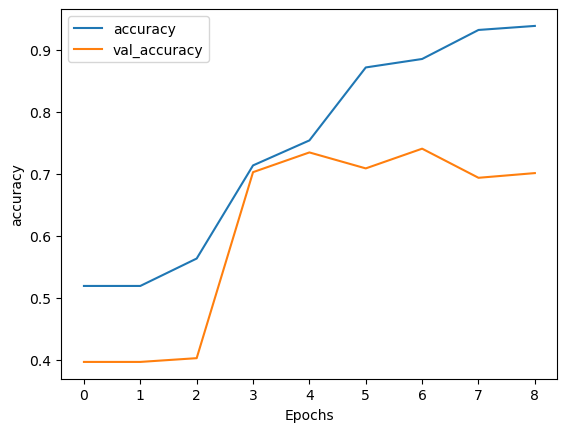

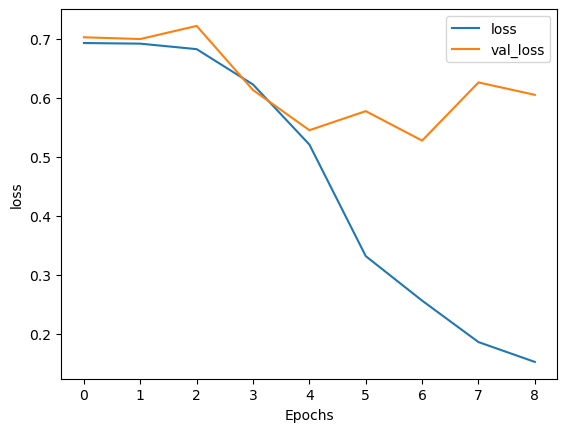

In [26]:
#Graph training and validation accuracy & loss
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")